In [1]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import math

%matplotlib inline

In [169]:
def pcen(x, eps=1E-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False, empty=True):
    frames = x.split(1, -2)
    m_frames = []
    if empty:
        last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):
    def __init__(self, eps=1E-9, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=False, **stft_kwargs):
        super().__init__()
        if trainable:
            self.s = nn.Parameter(torch.Tensor([s]))
            self.alpha = nn.Parameter(torch.Tensor([alpha]))
            self.delta = nn.Parameter(torch.Tensor([delta]))
            self.r = nn.Parameter(torch.Tensor([r]))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable


    def forward(self, x):
        return pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)

In [226]:
slice_len = 2
slice_count=1
sr = 44100
n_mels = 256
fmin =20
hop_length   = int(sr/(n_mels/slice_len)) # ensures slice_len seconds per height
fmax         = sr//2

y = librosa.effects.trim(librosa.load('../../input/train_curated/0006ae4e.wav' , sr)[0])[0]

s = librosa.feature.melspectrogram(y, 
                                     sr=sr,
                                     n_mels=n_mels,
                                     hop_length=hop_length,
                                     n_fft=n_mels*20,
                                     fmin=fmin,
                                     fmax=fmax)

t = torch.tensor(s)

slice_len = 2
slice_count=1
sr = 44100
n_mels = 256
fmin =20
hop_length   = int(sr/(n_mels/slice_len)) # ensures slice_len seconds per height
fmax         = sr//2

y = librosa.effects.trim(librosa.load('../../input/train_noisy/42f7abb4.wav' , sr)[0])[0]

s = librosa.feature.melspectrogram(y, 
                                     sr=sr,
                                     n_mels=n_mels,
                                     hop_length=hop_length,
                                     n_fft=n_mels*20,
                                     fmin=fmin,
                                     fmax=fmax)

t = torch.tensor(s)

time_constant = 0.4

T = time_constant * sr / hop_length

b = (math.sqrt(1 + 4* T**2) - 1) / (2 * T**2)

pcen_torch = pcen(t[None,...].permute((0,2,1)), eps=1e-9, s=b, alpha=0.6, delta=0.1, r=0.2, training=True)


pcen_librosa = librosa.core.pcen(s, 
                        sr=sr,
                        hop_length=hop_length,
                        gain = 0.6,
                        bias = 0.1,
                        power = 0.2,
                        time_constant = time_constant,
                        eps=1e-9
                       )

pcen_librosa_crop_before = librosa.core.pcen(s[:,350:706], 
                        sr=sr,
                        hop_length=hop_length,
                        gain = 0.6,
                        bias = 0.1,
                        power = 0.2,
                        time_constant = time_constant,
                        eps=1e-9
                       )[:,50:256+50]

pcen_librosa_crop_after = pcen_librosa[:,400:656]


In [227]:
pcen_librosa_crop_after.shape, pcen_librosa_crop_before.shape

((256, 256), (256, 256))

In [228]:
pcen_torch.permute((0,2,1)).float().squeeze() - torch.tensor(pcen_librosa).float()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [229]:
(pcen_torch.permute((0,2,1)).float().squeeze() - torch.tensor(pcen_librosa).float()).std()

tensor(0.)

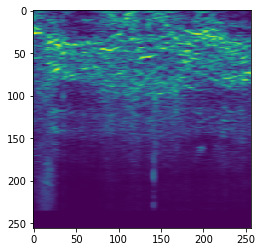

In [230]:
plt.imshow(pcen_librosa_crop_after)

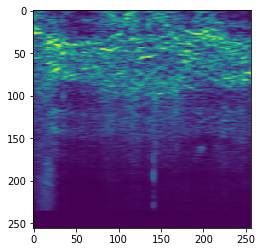

In [231]:
plt.imshow(pcen_librosa_crop_before)

In [235]:
(pcen_librosa_crop_before-pcen_librosa_crop_after).std()

0.01955044713366391

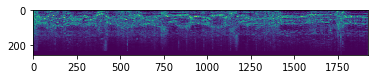

In [233]:
plt.imshow(pcen_librosa)

In [ ]:

slice_len = 2
slice_count=1
sr = 44100
n_mels = 256
fmin =20
hop_length   = int(sr/(n_mels/slice_len)) # ensures slice_len seconds per height
fmax         = sr//2

t = torch.tensor(s)

time_constant = 0.4

T = time_constant * sr / hop_length

b = (math.sqrt(1 + 4* T**2) - 1) / (2 * T**2)

eps=1e-9, s=b, alpha=0.6, delta=0.1, r=0.2, training=True)
